# Titanic Classification Model

**Notebook by:  Steven Yan, Flatiron School Data Science Immersive Online**

**Instructors:  Fangfang Lee, Justin Tannenbaum**

**Completed as Phase 3 Project Follow-up**

In [70]:
# # reload file with functions
# %load_ext autoreload
# %autoreload 2

import numpy as np 
import pandas as pd
import re

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import scikitplot as skplt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from utils import *

%reload_ext autoreload
%autoreload 2

## Loading Datasets

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Exploratory Data Analysis

### Features Key

1. survival: survived? 0 = No, 1 = Yes
2. pclass: ticket class indicative of socio-economic class
    - 1 = Upper, 2 = Middle, 3 = Lower
3. sex: Male or Female
4. Age: Age in years
    - fractional if less than 1. If the age is estimated, is it in the form of xx.5
5. sibsp: # of siblings / spouses aboard the Titanic
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés ignored)
6. parch: # of parents / children aboard the Titanic
    - Parent = mother, father	(nannies not included)
    - Child = daughter, son, stepdaughter, stepson
7. ticket: Ticket number	
8. fare: Passenger fare	
9. cabin: Cabin number	
10. embarked: Port of Embarkation	
    - C = Cherbourg, Q = Queenstown, S = Southampton


### Identifying Missing Value 

<AxesSubplot:>

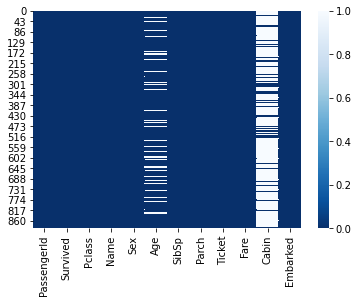

In [3]:
sns.heatmap(train.isna(), cmap='Blues_r')

<AxesSubplot:>

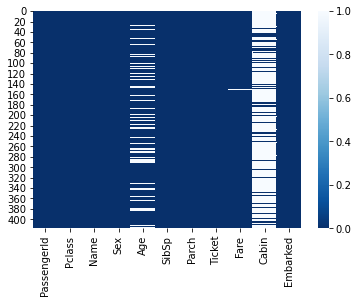

In [4]:
sns.heatmap(test.isna(), cmap='Blues_r')

In [5]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing.head(5)

Total     %
Cabin       687  77.1
Age         177  19.9
Embarked      2   0.2
Fare          0   0.0
Ticket        0   0.0

## Data Preprocessing

### Filling missing Values

In [6]:
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [7]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [8]:
data = [train, test]

for dataset in data:
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    dataset["Age"][np.isnan(dataset['Age'])] = rand_age
    dataset["Age"] = dataset["Age"].astype(int)

In [9]:
data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map(titles)
    dataset['Title'] = dataset['Title'].fillna(0)

train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [10]:
genders = {"male": 0, "female": 1}
data = [train, test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [11]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [12]:
data = [train, test]

for dataset in data:
    dataset.loc[dataset['Fare'] < 8, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] >= 8) & (dataset['Fare'] < 12), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] >= 12) & (dataset['Fare'] < 30), 'Fare'] = 2
    dataset.loc[dataset['Fare'] >= 30, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

for dataset in data:
    dataset.loc[dataset['Age'] < 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] >= 15) & (dataset['Age'] < 25), 'Age'] = 1
    dataset.loc[(dataset['Age'] >= 25) & (dataset['Age'] < 65), 'Age'] = 2
    dataset.loc[dataset['Age'] >= 65, 'Age'] = 3


In [13]:
train = train.drop(['Ticket', 'PassengerId'], axis=1)
test = test.drop(['Ticket', 'PassengerId'], axis=1)

In [14]:
data = [train, test]
for dataset in data:
    dataset['Related'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Related'] > 0, 'Not_Solo'] = 0
    dataset.loc[dataset['Related'] == 0, 'Not_Solo'] = 1
    dataset['Not_Solo'] = dataset['Not_Solo'].astype(int)

for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

In [15]:
train.head()

Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Deck  Title  \
0         0       3    0    1      1      0     0         0     8      1   
1         1       1    1    2      1      0     3         1     3      3   
2         1       3    1    2      0      0     0         0     8      2   
3         1       1    1    2      1      0     3         0     3      3   
4         0       3    0    2      0      0     1         0     8      1   

   Related  Not_Solo  Age_Class  
0        1         0          3  
1        1         0          2  
2        0         1          6  
3        1         0          2  
4        0         1          6

In [16]:
test.head()

Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Deck  Title  Related  \
0       3    0    2      0      0     0         2     8      1        0   
1       3    1    2      1      0     0         0     8      3        1   
2       2    0    2      0      0     1         2     8      1        0   
3       3    0    2      0      0     1         0     8      1        0   
4       3    1    1      1      1     2         0     8      3        2   

   Not_Solo  Age_Class  
0         1          6  
1         0          6  
2         1          4  
3         1          6  
4         0          3

### Correlation Matrix

In [17]:
# plt.figure(figsize = (14,12))
# plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
# sns.heatmap(X_tr.corr(), annot = True, cmap = 'RdBu', linecolor = 'white', square = True, linewidths = 0.2)

<img src='images/corrmap.png'>

### Pairplots

In [18]:
# g = sns.pairplot(data=train, hue='Survived', palette='icefire',
#                  size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
# g.set(xticklabels=[])
# plt.savefig('pairplot.png')

<img src='images/pairplot.png'>

##  Modeling

- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbor
- Gaussian Naive Bayes classifier
- Decision Tree
- Random Forest
- Ada Boost Classifier 
- Linear Discriminant Analysis
- Gradient Boosting Classifier

In [22]:
X = train.drop(columns=['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_tr, y_tt = train_test_split(X, y, random_state=42)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_tt = scaler.transform(X_test)

### Logistic Regression

#### Precision 
- measure of classifier's exactness, ratio pf true postiive to the sum of true and false positives
- "for all instanes classified positive, what percent was correct?"
#### Recall 
- measure of classifier's completeness, ability of classifier to correctly find all positive instanes, ratio of true positives to sum of true positives and false negatives
- "for all instances that were actaully positive, what percent was classified correctly?"
#### F1 Score
- weighted harmonic mean of precision and recall
- generally F1 score are lower than accuracy measures as they embed precision and recall
- weighted average of F1 should be used to compare classifier models, not global accuracy
#### Support
- number of actual occurrences of the class in specified dataset
- imbalanced support in training data may indicate structural weaknesses in reported scores of classifier and could indiccate need for stratified sampling or rebalancing
- support doesn't change between models but instead diagnoses the evaluation process

Training Accuracy:  0.8143712574850299
Validation Accuracy:  0.8026905829596412
Training F1 Score:  0.7499999999999999
Validation F1 Score:  0.752808988764045
Training AUC Score:  0.8587932758702795
Validation AUC Score:  0.8826932751970485
Training Recall Score:  0.7351778656126482
Validation Recall Score:  0.7528089887640449
Training Precision Score:  0.7654320987654321
Validation Precision Score:  0.7528089887640449
Training Average Precision Score:  0.8281380612452666
Validation Average Precision Score:  0.8586466227553102

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       415
           1       0.77      0.74      0.75       253

    accuracy                           0.81       668
   macro avg       0.80      0.80      0.80       668
weighted avg       0.81      0.81      0.81       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

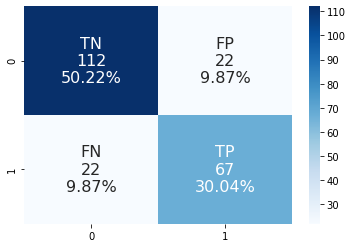

In [44]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_tt = logreg.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_log_tr, y_pred_log_tt, logreg)

### Random Forest Classifier

Training Accuracy:  0.9086826347305389
Validation Accuracy:  0.8026905829596412
Training F1 Score:  0.8710359408033826
Validation F1 Score:  0.7555555555555554
Training AUC Score:  0.9534739749511881
Validation AUC Score:  0.838210632232098
Training Recall Score:  0.8142292490118577
Validation Recall Score:  0.7640449438202247
Training Precision Score:  0.9363636363636364
Validation Precision Score:  0.7472527472527473
Training Average Precision Score:  0.9447553098893173
Validation Average Precision Score:  0.7930101763919974

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       415
           1       0.94      0.81      0.87       253

    accuracy                           0.91       668
   macro avg       0.92      0.89      0.90       668
weighted avg       0.91      0.91      0.91       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

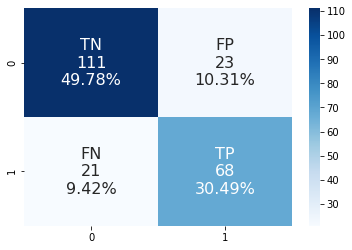

In [43]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_tt = rfc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_rfc_tr, y_pred_rfc_tt, rfc)

### Support Vector Machines

Training Accuracy:  0.8488023952095808
Validation Accuracy:  0.820627802690583
Training F1 Score:  0.7873684210526316
Validation F1 Score:  0.7647058823529411
Training AUC Score:  0.8911567217486547
Validation AUC Score:  0.8617306724802951
Training Recall Score:  0.7391304347826086
Validation Recall Score:  0.7303370786516854
Training Precision Score:  0.8423423423423423
Validation Precision Score:  0.8024691358024691
Training Average Precision Score:  0.8760490958871311
Validation Average Precision Score:  0.8495911754215564

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       415
           1       0.84      0.74      0.79       253

    accuracy                           0.85       668
   macro avg       0.85      0.83      0.84       668
weighted avg       0.85      0.85      0.85       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

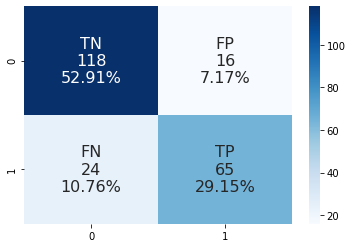

In [42]:
svc = SVC().fit(X_tr, y_tr)
y_pred_svc_tr = svc.predict(X_tr)
y_pred_svc_tt = svc.predict(X_tt)
get_metrics_svc(X_tr, y_tr, X_tt, y_tt, y_pred_svc_tr, y_pred_svc_tt, svc)

### K-Nearest Neighbors

Training Accuracy:  0.8592814371257484
Validation Accuracy:  0.8161434977578476
Training F1 Score:  0.7873303167420815
Validation F1 Score:  0.7421383647798743
Training AUC Score:  0.9006190770989095
Validation AUC Score:  0.8720861982223712
Training Recall Score:  0.6877470355731226
Validation Recall Score:  0.6629213483146067
Training Precision Score:  0.9206349206349206
Validation Precision Score:  0.8428571428571429
Training Average Precision Score:  0.856929773022902
Validation Average Precision Score:  0.7923672271485378

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       415
           1       0.92      0.69      0.79       253

    accuracy                           0.86       668
   macro avg       0.88      0.83      0.84       668
weighted avg       0.87      0.86      0.85       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

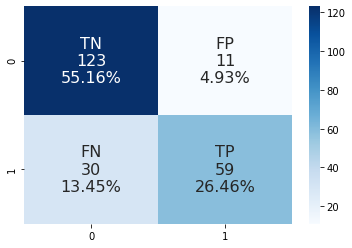

In [45]:
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_tt = knn.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_knn_tr, y_pred_knn_tt, knn)

### Gaussian Naive Bayes

Training Accuracy:  0.7844311377245509
Validation Accuracy:  0.7937219730941704
Training F1 Score:  0.7333333333333333
Validation F1 Score:  0.7676767676767676
Training AUC Score:  0.8341159102814419
Validation AUC Score:  0.8635753815193695
Training Recall Score:  0.782608695652174
Validation Recall Score:  0.8539325842696629
Training Precision Score:  0.6898954703832753
Validation Precision Score:  0.6972477064220184
Training Average Precision Score:  0.7760277184918734
Validation Average Precision Score:  0.8180777678807359

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       415
           1       0.69      0.78      0.73       253

    accuracy                           0.78       668
   macro avg       0.77      0.78      0.78       668
weighted avg       0.79      0.78      0.79       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

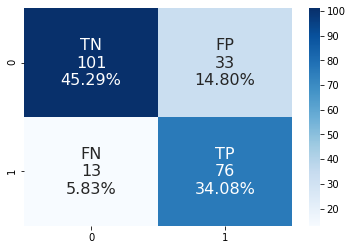

In [46]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_tt = gnb.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_gnb_tr, y_pred_gnb_tt, gnb)

### Decision Tree

Training Accuracy:  0.9086826347305389
Validation Accuracy:  0.8026905829596412
Training F1 Score:  0.8682505399568035
Validation F1 Score:  0.752808988764045
Training AUC Score:  0.9632458688508977
Validation AUC Score:  0.7766644306557102
Training Recall Score:  0.7944664031620553
Validation Recall Score:  0.7528089887640449
Training Precision Score:  0.9571428571428572
Validation Precision Score:  0.7528089887640449
Training Average Precision Score:  0.9488722481438193
Validation Average Precision Score:  0.6809164500804468

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       415
           1       0.96      0.79      0.87       253

    accuracy                           0.91       668
   macro avg       0.92      0.89      0.90       668
weighted avg       0.91      0.91      0.91       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

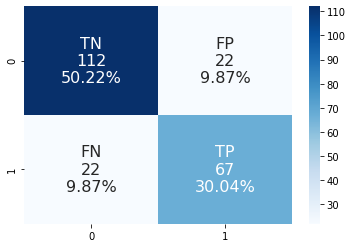

In [47]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_tt = dtc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_dtc_tr, y_pred_dtc_tt, dtc)

### AdaBoost

Training Accuracy:  0.8353293413173652
Validation Accuracy:  0.8026905829596412
Training F1 Score:  0.778225806451613
Validation F1 Score:  0.7582417582417582
Training AUC Score:  0.8914853088242296
Validation AUC Score:  0.8574962267315109
Training Recall Score:  0.7628458498023716
Validation Recall Score:  0.7752808988764045
Training Precision Score:  0.7942386831275721
Validation Precision Score:  0.7419354838709677
Training Average Precision Score:  0.869449647891777
Validation Average Precision Score:  0.7750958228982883

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       415
           1       0.79      0.76      0.78       253

    accuracy                           0.84       668
   macro avg       0.83      0.82      0.82       668
weighted avg       0.83      0.84      0.83       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

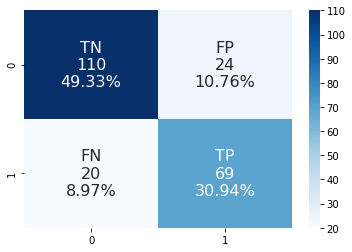

In [48]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_tt = abc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_abc_tr, y_pred_abc_tt, abc)

### Linear Discriminant Analysis

Training Accuracy:  0.8353293413173652
Validation Accuracy:  0.8026905829596412
Training F1 Score:  0.778225806451613
Validation F1 Score:  0.7582417582417582
Training AUC Score:  0.858631363398257
Validation AUC Score:  0.8805131645145061
Training Recall Score:  0.7628458498023716
Validation Recall Score:  0.7752808988764045
Training Precision Score:  0.7942386831275721
Validation Precision Score:  0.7419354838709677
Training Average Precision Score:  0.8282515625892788
Validation Average Precision Score:  0.8550890589750121

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       415
           1       0.79      0.76      0.78       253

    accuracy                           0.84       668
   macro avg       0.83      0.82      0.82       668
weighted avg       0.83      0.84      0.83       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

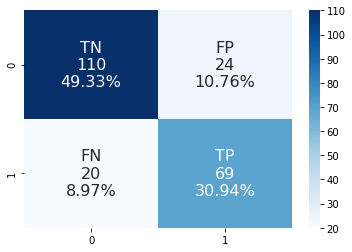

In [49]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = abc.predict(X_tr)
y_pred_lda_tt = abc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_lda_tr, y_pred_lda_tt, lda)

### Gradient Boosting

Training Accuracy:  0.8802395209580839
Validation Accuracy:  0.8251121076233184
Training F1 Score:  0.8353909465020577
Validation F1 Score:  0.782122905027933
Training AUC Score:  0.9315205485975522
Validation AUC Score:  0.8614791212476942
Training Recall Score:  0.8023715415019763
Validation Recall Score:  0.7865168539325843
Training Precision Score:  0.871244635193133
Validation Precision Score:  0.7777777777777778
Training Average Precision Score:  0.9184706803531806
Validation Average Precision Score:  0.8320781411366303

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       415
           1       0.87      0.80      0.84       253

    accuracy                           0.88       668
   macro avg       0.88      0.87      0.87       668
weighted avg       0.88      0.88      0.88       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

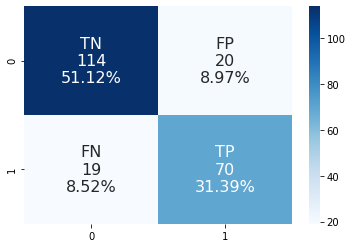

In [50]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_tt = gbc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_gbc_tr, y_pred_gbc_tt, gbc)

# XGBoost Classifier

Training Accuracy:  0.9041916167664671
Validation Accuracy:  0.8116591928251121
Training F1 Score:  0.8655462184873949
Validation F1 Score:  0.7666666666666667
Training AUC Score:  0.9518024667841325
Validation AUC Score:  0.8516686231762536
Training Recall Score:  0.8142292490118577
Validation Recall Score:  0.7752808988764045
Training Precision Score:  0.9237668161434978
Validation Precision Score:  0.7582417582417582
Training Average Precision Score:  0.9433906885063955
Validation Average Precision Score:  0.8256029096494453

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       415
           1       0.92      0.81      0.87       253

    accuracy                           0.90       668
   macro avg       0.91      0.89      0.90       668
weighted avg       0.91      0.90      0.90       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

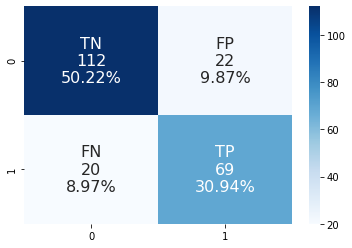

In [51]:
xgb = XGBClassifier(verbosity = 0).fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_tt = xgb.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_xgb_tr, y_pred_xgb_tt, xgb)

## Model evaluation
We can now rank our evaluation of all the models to choose the best one for our problem.

In [53]:
data = {'Accuracy': [accuracy(y_tt, y_pred_log_tt), 
                     accuracy(y_tt, y_pred_rfc_tt), 
                     accuracy(y_tt, y_pred_knn_tt), 
                     accuracy(y_tt, y_pred_gnb_tt), 
                     accuracy(y_tt, y_pred_dtc_tt), 
                     accuracy(y_tt, y_pred_abc_tt), 
                     accuracy(y_tt, y_pred_lda_tt), 
                     accuracy(y_tt, y_pred_gbc_tt),
                     accuracy(y_tt, y_pred_svc_tt),
                     accuracy(y_tt, y_pred_xgb_tt)],
        'F1 Score': [f1(y_tt, y_pred_log_tt), 
                     f1(y_tt, y_pred_rfc_tt), 
                     f1(y_tt, y_pred_knn_tt), 
                     f1(y_tt, y_pred_gnb_tt), 
                     f1(y_tt, y_pred_dtc_tt), 
                     f1(y_tt, y_pred_abc_tt), 
                     f1(y_tt, y_pred_lda_tt), 
                     f1(y_tt, y_pred_gbc_tt),
                     f1(y_tt, y_pred_svc_tt),
                     f1(y_tt, y_pred_xgb_tt)],
        'AUC Score': [roc_auc_score(y_tt, logreg.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, rfc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, knn.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, gnb.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, dtc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, abc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, lda.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, gbc.predict_proba(X_tt)[:,1]),
                      roc_auc_score(y_tt, svc.decision_function(X_tt)),
                      roc_auc_score(y_tt, xgb.predict_proba(X_tt)[:,1])],
        'Recall': [recall(y_tt, y_pred_log_tt), 
                   recall(y_tt, y_pred_rfc_tt), 
                   recall(y_tt, y_pred_knn_tt), 
                   recall(y_tt, y_pred_gnb_tt), 
                   recall(y_tt, y_pred_dtc_tt), 
                   recall(y_tt, y_pred_abc_tt), 
                   recall(y_tt, y_pred_lda_tt), 
                   recall(y_tt, y_pred_gbc_tt),
                   recall(y_tt, y_pred_svc_tt),
                   recall(y_tt, y_pred_xgb_tt)],
        'Precision': [precision(y_tt, y_pred_log_tt), 
                      precision(y_tt, y_pred_rfc_tt), 
                      precision(y_tt, y_pred_knn_tt), 
                      precision(y_tt, y_pred_gnb_tt), 
                      precision(y_tt, y_pred_dtc_tt), 
                      precision(y_tt, y_pred_abc_tt), 
                      precision(y_tt, y_pred_lda_tt), 
                      precision(y_tt, y_pred_gbc_tt),
                      precision(y_tt, y_pred_svc_tt),
                      precision(y_tt, y_pred_xgb_tt)]}
scores = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Decision Tree Classifier', 
                                          'AdaBoost Classifier', 
                                          'Linear Discriminant Analysis', 
                                          'Gradient Boosting Classifier',
                                          'Support Vector Machine',
                                          'XGBoost Classifier'])
scores

Accuracy  F1 Score  AUC Score    Recall  \
Logistic Regression           0.802691  0.752809   0.882693  0.752809   
Random Forest Classifier      0.802691  0.755556   0.838211  0.764045   
K-Nearest Neighbors           0.816143  0.742138   0.872086  0.662921   
Gaussian Naive Bayes          0.793722  0.767677   0.863575  0.853933   
Decision Tree Classifier      0.802691  0.752809   0.776664  0.752809   
AdaBoost Classifier           0.802691  0.758242   0.857496  0.775281   
Linear Discriminant Analysis  0.802691  0.758242   0.880513  0.775281   
Gradient Boosting Classifier  0.825112  0.782123   0.861479  0.786517   
Support Vector Machine        0.820628  0.764706   0.861731  0.730337   
XGBoost Classifier            0.811659  0.766667   0.851669  0.775281   

                              Precision  
Logistic Regression            0.752809  
Random Forest Classifier       0.747253  
K-Nearest Neighbors            0.842857  
Gaussian Naive Bayes           0.697248  
Decision Tree Classifier       0.752809  
AdaBoost Classifier            0.741935  
Linear Discriminant Analysis   0.741935  
Gradient Boosting Classifier   0.777778  
Support Vector Machine         0.802469  
XGBoost Classifier             0.758242

## Decision Tree, Bagging Classifier, Random Forest

Training Accuracy:  0.8562874251497006
Validation Accuracy:  0.820627802690583
Training F1 Score:  0.7828054298642534
Validation F1 Score:  0.7590361445783134
Training AUC Score:  0.9110386208867088
Validation AUC Score:  0.8478953546872379
Training Recall Score:  0.6837944664031621
Validation Recall Score:  0.7078651685393258
Training Precision Score:  0.9153439153439153
Validation Precision Score:  0.8181818181818182
Training Average Precision Score:  0.8813331091202963
Validation Average Precision Score:  0.7880792675154786

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       415
           1       0.92      0.68      0.78       253

    accuracy                           0.86       668
   macro avg       0.87      0.82      0.84       668
weighted avg       0.86      0.86      0.85       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

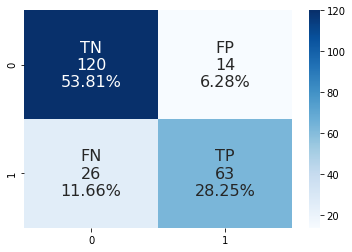

In [54]:
dtc2 = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtc2.fit(X_tr, y_tr)
y_pred_dtc2_tr = dtc2.predict(X_tr)
y_pred_dtc2_tt = dtc2.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_dtc2_tr, y_pred_dtc2_tt, dtc2)

In [55]:
dtc2.feature_importances_

array([0.15754338, 0.        , 0.        , 0.        , 0.00518193,
       0.01681898, 0.02410671, 0.05870563, 0.60768737, 0.07970234,
       0.        , 0.05025367])

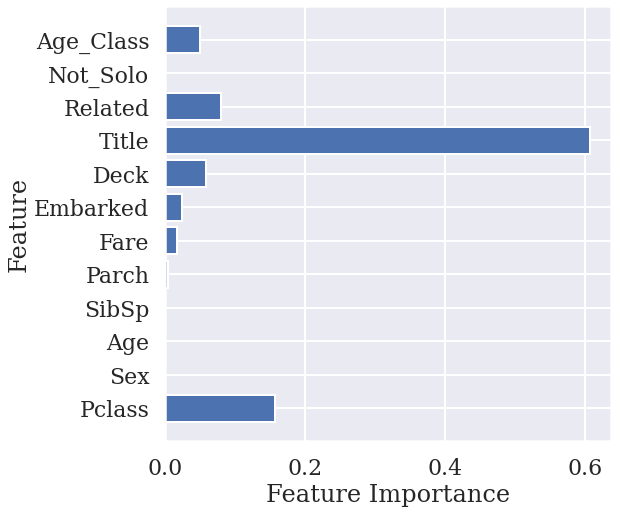

In [62]:
plot_feature_importances(X_train, dtc2)
plt.savefig('images/dtc2_feature_importance.png')

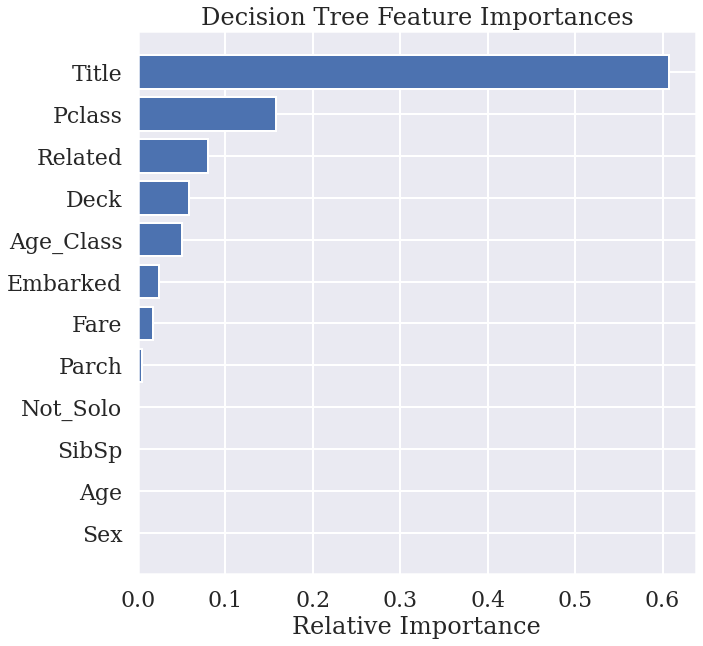

In [65]:
importances = dtc2.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
sns.set_theme(style="darkgrid", font='serif', context='poster')
plt.figure(figsize=(10,10))
plt.title('Decision Tree Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.savefig('images/dtc_feature_importance.png')

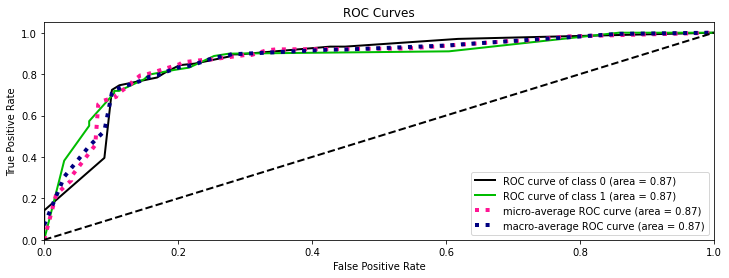

In [172]:

y_pred_proba = dtc2.predict_proba(X_tt)
skplt.metrics.plot_roc_curve(y_tt, y_pred_proba)
plt.show()


Training Accuracy:  0.8652694610778443
Validation Accuracy:  0.8116591928251121
Training F1 Score:  0.8148148148148149
Validation F1 Score:  0.7586206896551726
Training AUC Score:  0.9196295061669604
Validation AUC Score:  0.8763206439711553
Training Recall Score:  0.782608695652174
Validation Recall Score:  0.7415730337078652
Training Precision Score:  0.8497854077253219
Validation Precision Score:  0.7764705882352941
Training Average Precision Score:  0.9051652838450528
Validation Average Precision Score:  0.842857209522778

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       415
           1       0.85      0.78      0.81       253

    accuracy                           0.87       668
   macro avg       0.86      0.85      0.85       668
weighted avg       0.86      0.87      0.86       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

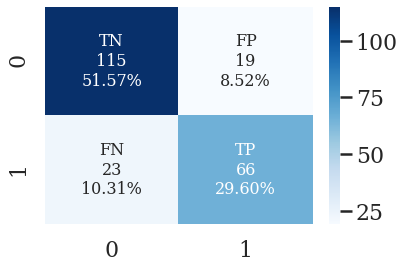

In [58]:
bc = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20).fit(X_tr, y_tr)
y_pred_bc_tr = bc.predict(X_tr)
y_pred_bc_tt = bc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_bc_tr, y_pred_bc_tt, bc)

Training Accuracy:  0.844311377245509
Validation Accuracy:  0.820627802690583
Training F1 Score:  0.7842323651452282
Validation F1 Score:  0.7647058823529411
Training AUC Score:  0.9066050764322111
Validation AUC Score:  0.8848733858795907
Training Recall Score:  0.7470355731225297
Validation Recall Score:  0.7303370786516854
Training Precision Score:  0.8253275109170306
Validation Precision Score:  0.8024691358024691
Training Average Precision Score:  0.8932878733821821
Validation Average Precision Score:  0.8593427641227536

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       415
           1       0.83      0.75      0.78       253

    accuracy                           0.84       668
   macro avg       0.84      0.83      0.83       668
weighted avg       0.84      0.84      0.84       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

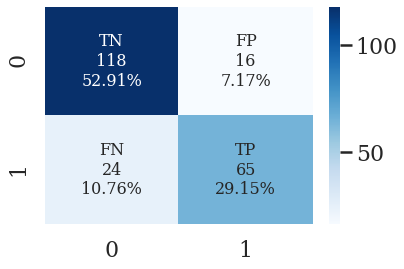

In [59]:
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_tr, y_tr)
y_pred_rfc2_tr = rfc2.predict(X_tr)
y_pred_rfc2_tt = rfc2.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_rfc2_tr, y_pred_rfc2_tt, rfc2)

In [60]:
rfc2.feature_importances_

array([0.09589693, 0.2517825 , 0.02336293, 0.03747469, 0.02072518,
       0.04880774, 0.02400385, 0.0691064 , 0.29107515, 0.06104369,
       0.00899079, 0.06773015])

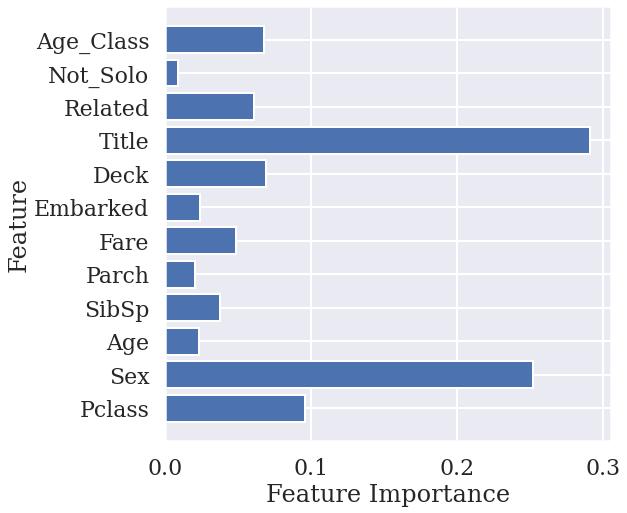

In [66]:
plot_feature_importances(X_train, rfc2)
plt.savefig('images/rf_feature_importance.png')

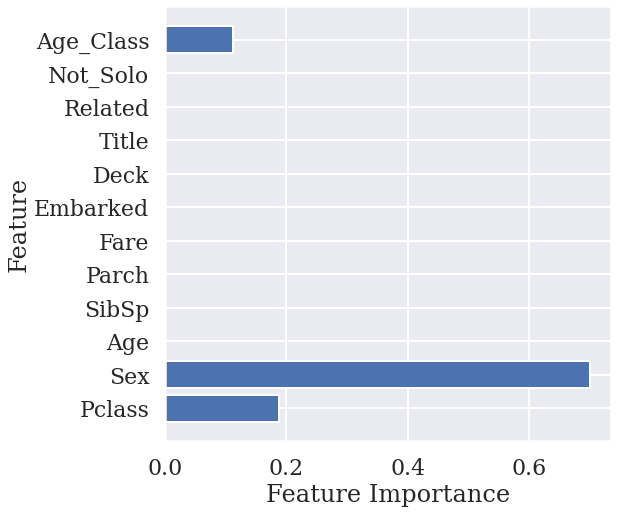

In [67]:
rfc3 = RandomForestClassifier(n_estimators=5, max_features=10, max_depth=2).fit(X_tr, y_tr)
rf_tree_1 = rfc3.estimators_[0]
plot_feature_importances(X_train, rf_tree_1)

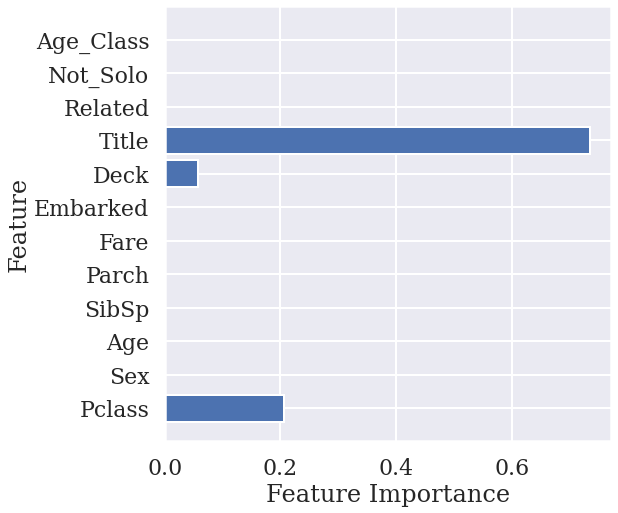

In [68]:
rf_tree_2 = rfc3.estimators_[1]
plot_feature_importances(X_train, rf_tree_2)

## Voting Classifier with Random Forest, SVC, and Logistic Regression

In [71]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [72]:
voting_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [73]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_tt)
    print(clf.__class__.__name__, accuracy_score(y_tt, y_pred))

LogisticRegression 0.8026905829596412
RandomForestClassifier 0.7937219730941704
SVC 0.820627802690583
VotingClassifier 0.820627802690583


In [74]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

vc = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
vc.fit(X_tr, y_tr)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [75]:
for clf in (log_clf, rnd_clf, svm_clf, vc):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_tt)
    print(clf.__class__.__name__, accuracy_score(y_tt, y_pred))

LogisticRegression 0.8026905829596412
RandomForestClassifier 0.7937219730941704
SVC 0.820627802690583
VotingClassifier 0.8251121076233184


Training Accuracy:  0.8667664670658682
Validation Accuracy:  0.8251121076233184
Training F1 Score:  0.81419624217119
Validation F1 Score:  0.7719298245614036
Training AUC Score:  0.9261583884946902
Validation AUC Score:  0.8762367935602885
Training Recall Score:  0.7707509881422925
Validation Recall Score:  0.7415730337078652
Training Precision Score:  0.8628318584070797
Validation Precision Score:  0.8048780487804879
Training Average Precision Score:  0.9134638902503269
Validation Average Precision Score:  0.8620685105501908

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       415
           1       0.86      0.77      0.81       253

    accuracy                           0.87       668
   macro avg       0.87      0.85      0.86       668
weighted avg       0.87      0.87      0.87       668


Validation Classification Report: 
              precision    recall  f1-score   support

           0    

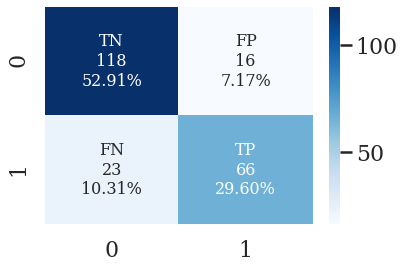

In [76]:
y_pred_vc_tr = vc.predict(X_tr)
y_pred_vc_tt = vc.predict(X_tt)
get_metrics(X_tr, y_tr, X_tt, y_tt, y_pred_vc_tr, y_pred_vc_tt, vc)

## Hyperparameters Tuning

**Parameters**

- n_jobs : Number of cores used for the training process. If set to -1, all cores are used.
- n_estimators : Number of classification trees in your learning model ( set to 10 per default)
- max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep
- verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.


## XGBoost Classifier with GridSearchCV

Grid Search found the following optimal parameters: 
learning_rate: 0.01
max_depth: 5
min_child_weight: 1
n_estimators: 100
subsample: 0.9
Training Accuracy:  0.8592814371257484
Testing Accuracy:  0.8295964125560538
Training F1 Score:  0.8008474576271186
Testing F1 Score:  0.7840909090909092
Training AUC Score: 0.9102052478689461
Testing AUC Score: 0.8758175415059535
Training Recall Score:  0.7470355731225297
Testing Recall Score:  0.7752808988764045
Training Precision Score:  0.863013698630137
Testing Precision Score:  0.7931034482758621

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       415
           1       0.86      0.75      0.80       253

    accuracy                           0.86       668
   macro avg       0.86      0.84      0.85       668
weighted avg       0.86      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

      

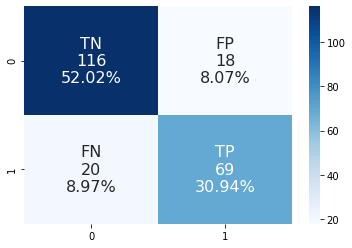

In [246]:
xgb2 = XGBClassifier(verbosity = 0).fit(X_tr, y_tr)
y_pred_xgb2_tr = xgb2.predict(X_tr)
y_pred_xgb2_tt = xgb2.predict(X_tt)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 6, 8],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.9, 1.1],
    'n_estimators': [100, 200, 300],
}
grid_xgb2 = GridSearchCV(xgb2, param_grid, scoring='accuracy', cv=None, n_jobs=1).fit(X_tr, y_tr)
best_param_xgb = grid_xgb2.best_params_
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_param_xgb.keys()):
    print('%s: %r' % (param_name, best_param_xgb[param_name]))
y_pred_xgbgs2_tr = grid_xgb2.predict(X_tr)
y_pred_xgbgs2_tt = grid_xgb2.predict(X_tt)
print("")
get_metrics(y_tr, y_tt, y_pred_xgbgs2_tr, y_pred_xgbgs2_tt, grid_xgb2)

# Grid Search found the following optimal parameters: 
# learning_rate: 0.01
# max_depth: 5
# min_child_weight: 1
# n_estimators: 100
# subsample: 0.9

### GBC Feature Importance


Model Report
Accuracy : 0.8653
AUC Score (Train): 0.918781
CV Score : Mean - 0.8711452 | Std - 0.04021398 | Min - 0.8110294 | Max - 0.9251429


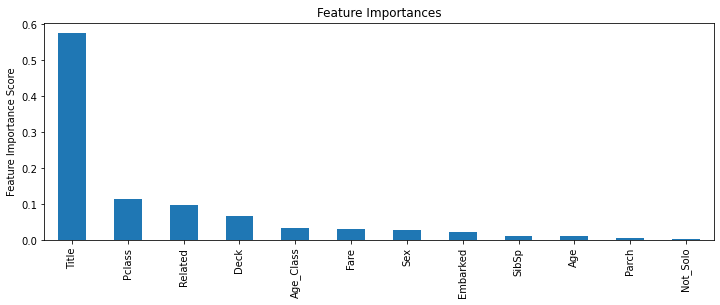

In [95]:
predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=42)
modelfit(gbm0, train, predictors)

### Gradient Boosting with GridSearchCV

In [33]:
gbc2 = GradientBoostingClassifier()
param_grid = {'n_estimators' : [10, 50, 100, 200, 400],
              'learning_rate': [0.25, 0.1, 0.05, 0.01, 0.001],
              'max_depth': [2, 4, 6, 8],
              'max_features': ['auto', 'log2', 'sqrt'],
              'min_samples_split': [0.05, 0.1, 0.25, 0.5],
              'min_samples_leaf': [0.05, 0.1, 0.25, 0.5] 
              }
gbm = GridSearchCV(gbc2, param_grid=param_grid, cv=5, scoring="accuracy", verbose=1)
gbm.fit(X_train, y_train)
print(f"Training Accuracy: {gbm.best_score_ :.2%}")
gbm.best_estimator_

# Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
# Training Accuracy: 83.50%
# GradientBoostingClassifier(learning_rate=0.25, max_depth=4, max_features='auto',
#                            min_samples_leaf=0.05, min_samples_split=0.25,
#                            n_estimators=50)

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Training Accuracy: 83.50%


GradientBoostingClassifier(learning_rate=0.25, max_depth=4, max_features='auto',
                           min_samples_leaf=0.05, min_samples_split=0.25,
                           n_estimators=50)

Training Accuracy:  0.8592814371257484
Testing Accuracy:  0.8116591928251121
Training F1 Score:  0.8065843621399176
Testing F1 Score:  0.7613636363636362
Training AUC Score: 0.9084099242821086
Testing AUC Score: 0.877033372463525
Training Recall Score:  0.7747035573122529
Testing Recall Score:  0.7528089887640449
Training Precision Score:  0.8412017167381974
Testing Precision Score:  0.7701149425287356

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       415
           1       0.84      0.77      0.81       253

    accuracy                           0.86       668
   macro avg       0.86      0.84      0.85       668
weighted avg       0.86      0.86      0.86       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       134
           1       0.77      0.75      0.76        89

    accuracy                        

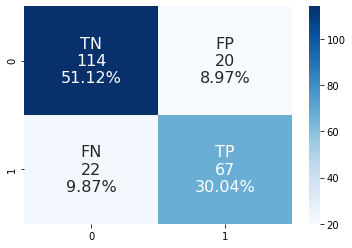

In [247]:
gbc_best = GradientBoostingClassifier(learning_rate=0.25,
                                   max_depth=4,
                                   max_features='auto',
                                   min_samples_leaf=0.05,
                                   min_samples_split=0.25,
                                   n_estimators=50).fit(X_tr, y_tr)
y_pred_gbc_best_tr = gbc_best.predict(X_tr)
y_pred_gbc_best_tt = gbc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_gbc_best_tr, y_pred_gbc_best_tt, gbc_best)

In [ ]:
4152370403

### Decision Tree and Random Forest with GridSearchCV

In [71]:
dtc3 = DecisionTreeClassifier()
dtc_cv_score = cross_val_score(dtc3, X_train, y_train, cv=3)
mean_dtc_cv_score = np.mean(dtc_cv_score)
print(f"Mean Cross Validation Score: {mean_dtc_cv_score :.2%}")

Mean Cross Validation Score: 81.37%


In [75]:
dt_param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None, 2, 4, 6, 8, 12],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6]
              }
dtc_grid_search = GridSearchCV(dtc3, dt_param_grid, cv=3, return_train_score=True, scoring="accuracy")
dtc_grid_search.fit(X_train, y_train)
dtc_gs_score = np.mean(dtc_grid_search.cv_results_['mean_train_score'])
print(f"Mean Training Score: {dtc_gs_score :.2%}")
print(f"Training Accuracy: {model.best_score_ :.2%}")
print("Best Parameter Combination:") 
dtc_grid_search.best_params_

# Mean Training Score: 84.99%
# Best Parameter Combination:
# {'criterion': 'gini',
#  'max_depth': 4,
#  'min_samples_leaf': 2,
#  'min_samples_split': 2}

Mean Training Score: 84.99%
Best Parameter Combination:


{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

Training Accuracy:  0.844311377245509
Testing Accuracy:  0.8161434977578476
Training F1 Score:  0.7886178861788619
Testing F1 Score:  0.7709497206703911
Training AUC Score: 0.8943092528215629
Testing AUC Score: 0.8666359215160154
Training Recall Score:  0.766798418972332
Testing Recall Score:  0.7752808988764045
Training Precision Score:  0.8117154811715481
Testing Precision Score:  0.7666666666666667

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       415
           1       0.81      0.77      0.79       253

    accuracy                           0.84       668
   macro avg       0.84      0.83      0.83       668
weighted avg       0.84      0.84      0.84       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       134
           1       0.77      0.78      0.77        89

    accuracy                         

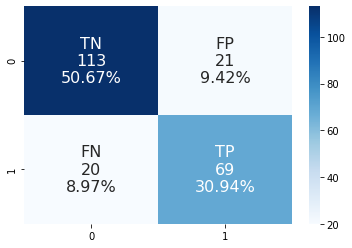

In [250]:
dtc_best = DecisionTreeClassifier(criterion='gini',
                                  max_depth=4,
                                  min_samples_leaf=2,
                                  min_samples_split=2).fit(X_tr, y_tr)
y_pred_dtc_best_tr = dtc_best.predict(X_tr)
y_pred_dtc_best_tt = dtc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_dtc_best_tr, y_pred_dtc_best_tt, dtc_best)

In [76]:
rf_2 = RandomForestClassifier()
rf_2_cv_score = np.mean(cross_val_score(rf_2, X_train, y_train, cv=3))
print(f"Mean Cross Validation Score: {rf_2_cv_score :.2%}")
param_grid = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 50, 100, 250, 500],
              'max_depth': [None, 2, 6, 12],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [3, 6]
              }
rf_gs = GridSearchCV(rf_2, param_grid, cv=3, scoring="accuracy", verbose=1)
rf_gs.fit(X_train, y_train)
print(f"Training Accuracy: {rf_gs.best_score_ :.2%}")
rf_gs.best_estimator_

# Mean Cross Validation Score: 82.15%
# Fitting 3 folds for each of 240 candidates, totalling 720 fits
# Training Accuracy: 83.39%
# RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
#                        n_estimators=50)

Mean Cross Validation Score: 82.15%
Fitting 3 folds for each of 240 candidates, totalling 720 fits
Training Accuracy: 83.39%


RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
                       n_estimators=50)

Training Accuracy:  0.8727544910179641
Testing Accuracy:  0.8340807174887892
Training F1 Score:  0.8225469728601252
Testing F1 Score:  0.783625730994152
Training AUC Score: 0.9210057621791514
Testing AUC Score: 0.8843702834143887
Training Recall Score:  0.7786561264822134
Testing Recall Score:  0.7528089887640449
Training Precision Score:  0.8716814159292036
Testing Precision Score:  0.8170731707317073

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       415
           1       0.87      0.78      0.82       253

    accuracy                           0.87       668
   macro avg       0.87      0.85      0.86       668
weighted avg       0.87      0.87      0.87       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       134
           1       0.82      0.75      0.78        89

    accuracy                        

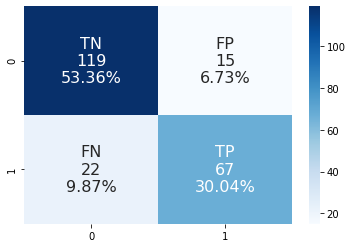

In [248]:
rfc_best = RandomForestClassifier(criterion='entropy', 
                                  max_depth=12, 
                                  min_samples_leaf=3,
                                  n_estimators=50).fit(X_tr, y_tr)
y_pred_rfc_best_tr = rfc_best.predict(X_tr)
y_pred_rfc_best_tt = rfc_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc_best_tr, y_pred_rfc_best_tt, rfc_best)

### Linear Discriminant Analysis with GridSearchCV

In [35]:
clf = LinearDiscriminantAnalysis()
param_grid = {'tol': [0.001, 0.01, 0.1, 0.2]}
model = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose=1)
model.fit(X_train, y_train)
print(f"Training Accuracy: {model.best_score_ :.2%}")
model.best_estimator_

# Fitting 5 folds for each of 4 candidates, totalling 20 fits
# Training Accuracy: 80.25%
# LinearDiscriminantAnalysis(tol=0.001)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training Accuracy: 80.25%


LinearDiscriminantAnalysis(tol=0.001)

Training Accuracy:  0.8083832335329342
Testing Accuracy:  0.7847533632286996
Training F1 Score:  0.7398373983739838
Testing F1 Score:  0.7303370786516854
Training AUC Score: 0.8562979189485213
Testing AUC Score: 0.8785007546536978
Training Recall Score:  0.7193675889328063
Testing Recall Score:  0.7303370786516854
Training Precision Score:  0.7615062761506276
Testing Precision Score:  0.7303370786516854

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       415
           1       0.76      0.72      0.74       253

    accuracy                           0.81       668
   macro avg       0.80      0.79      0.79       668
weighted avg       0.81      0.81      0.81       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       134
           1       0.73      0.73      0.73        89

    accuracy                       

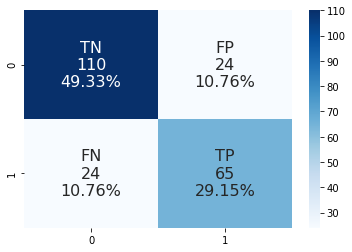

In [254]:
lda_best = LinearDiscriminantAnalysis(tol=0.001).fit(X_tr, y_tr)
y_pred_lda_best_tr = lda_best.predict(X_tr)
y_pred_lda_best_tt = lda_best.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_lda_best_tr, y_pred_lda_best_tt, lda_best)

### Support Vector Machines with GridSearchCV

In [36]:
clf = SVC()
param_grid = {'kernel': ['rbf', 'linear'], 
              'gamma': [ 0.001, 0.01, 0.1, 1],
              'C': [1, 10, 50, 100, 200, 300, 1000]}
model = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=4, verbose=1)
model.fit(X_train, y_train)
print(f"Training Accuracy: {model.best_score_ :.2%}")
model.best_estimator_

# Fitting 5 folds for each of 56 candidates, totalling 280 fits
# Training Accuracy: 82.60%
# SVC(C=50, gamma=0.01)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Training Accuracy: 82.60%


SVC(C=50, gamma=0.01)

Training Accuracy:  0.842814371257485
Testing Accuracy:  0.820627802690583
Training F1 Score:  0.7807933194154488
Testing F1 Score:  0.7674418604651162
Training Recall Score:  0.7391304347826086
Testing Recall Score:  0.7415730337078652
Training Precision Score:  0.827433628318584
Testing Precision Score:  0.7951807228915663

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       415
           1       0.83      0.74      0.78       253

    accuracy                           0.84       668
   macro avg       0.84      0.82      0.83       668
weighted avg       0.84      0.84      0.84       668


Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       134
           1       0.80      0.74      0.77        89

    accuracy                           0.82       223
   macro avg       0.82      0.81      0.81       223
weighte

<AxesSubplot:>

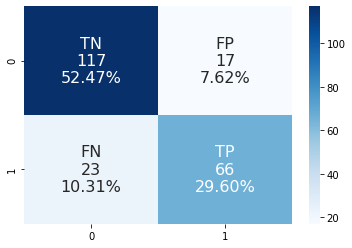

In [260]:
svc_best = SVC(C=50, gamma=0.01).fit(X_tr, y_tr)
y_pred_svc_best_tr = svc_best.predict(X_tr)
y_pred_svc_best_tt = svc_best.predict(X_tt)
cnf_matrix_svc_best = confusion_matrix(y_tt, y_pred_svc_best_tt)

print('Training Accuracy: ', accuracy(y_tr, y_pred_svc_best_tr))
print('Testing Accuracy: ', accuracy(y_tt, y_pred_svc_best_tt))
print('Training F1 Score: ', f1(y_tr, y_pred_svc_best_tr))
print('Testing F1 Score: ', f1(y_tt, y_pred_svc_best_tt))
#print('Training AUC Score: {}'.format(roc_auc_score(y_tr, svc.predict_proba(X_tr)[:,1])))
#print('Testing AUC Score: {}'.format(roc_auc_score(y_tt, svc.predict_proba(X_tt)[:,1])))
print('Training Recall Score: ', recall(y_tr, y_pred_svc_best_tr))
print('Testing Recall Score: ', recall(y_tt, y_pred_svc_best_tt))
print('Training Precision Score: ', precision(y_tr, y_pred_svc_best_tr))
print('Testing Precision Score: ', precision(y_tt, y_pred_svc_best_tt))
print('')
print("Training Classification Report: ")
print(classification_report(y_tr, y_pred_svc_best_tr))
print("")
print("Testing Classification Report: ")
print(classification_report(y_tt, y_pred_svc_best_tt))

group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in cnf_matrix_svc_best.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cnf_matrix_svc_best.flatten()/np.sum(cnf_matrix_svc_best)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix_svc_best, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

In [261]:
data_2 = {'Accuracy': [accuracy(y_tt, y_pred_dtc2_tt), 
                       accuracy(y_tt, y_pred_rfc2_tt), 
                       accuracy(y_tt, y_pred_vc_tt), 
                       accuracy(y_tt, y_pred_bc_tt), 
                       accuracy(y_tt, y_pred_xgb2_tt), 
                       accuracy(y_tt, y_pred_gbc_best_tt), 
                       accuracy(y_tt, y_pred_rfc_best_tt), 
                       accuracy(y_tt, y_pred_dtc_best_tt),
                       accuracy(y_tt, y_pred_lda_best_tt),
                       accuracy(y_tt, y_pred_svc_best_tt)],
          'F1 Score': [f1(y_tt, y_pred_dtc2_tt), 
                       f1(y_tt, y_pred_rfc2_tt), 
                       f1(y_tt, y_pred_vc_tt), 
                       f1(y_tt, y_pred_bc_tt), 
                       f1(y_tt, y_pred_xgb2_tt), 
                       f1(y_tt, y_pred_gbc_best_tt), 
                       f1(y_tt, y_pred_rfc_best_tt), 
                       f1(y_tt, y_pred_dtc_best_tt),
                       f1(y_tt, y_pred_lda_best_tt),
                       f1(y_tt, y_pred_svc_best_tt)],
          'AUC Score': [roc_auc_score(y_tt, dtc2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, rfc2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, vc.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, bc.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, xgb2.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, gbc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, rfc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, dtc_best.predict_proba(X_tt)[:,1]),
                        roc_auc_score(y_tt, lda_best.predict_proba(X_tt)[:,1]),
                        np.nan],
          'Recall': [recall(y_tt, y_pred_dtc2_tt), 
                     recall(y_tt, y_pred_rfc2_tt), 
                     recall(y_tt, y_pred_vc_tt), 
                     recall(y_tt, y_pred_bc_tt), 
                     recall(y_tt, y_pred_xgb2_tt), 
                     recall(y_tt, y_pred_gbc_best_tt), 
                     recall(y_tt, y_pred_rfc_best_tt), 
                     recall(y_tt, y_pred_dtc_best_tt),
                     recall(y_tt, y_pred_lda_best_tt),
                     recall(y_tt, y_pred_svc_best_tt)],
          'Precision': [precision(y_tt, y_pred_dtc2_tt), 
                        precision(y_tt, y_pred_rfc2_tt), 
                        precision(y_tt, y_pred_vc_tt), 
                        precision(y_tt, y_pred_bc_tt), 
                        precision(y_tt, y_pred_xgb2_tt), 
                        precision(y_tt, y_pred_gbc_best_tt), 
                        precision(y_tt, y_pred_rfc_best_tt), 
                        precision(y_tt, y_pred_dtc_best_tt),
                        precision(y_tt, y_pred_lda_best_tt),
                        precision(y_tt, y_pred_svc_best_tt)]}
scores_2 = pd.DataFrame(data=data_2, index = ['Decision Tree Baseline', 
                                          'Random Forest Classifier', 
                                          'Voting Classifier', 
                                          'Bagging Classifier', 
                                          'XGBoost with GridSearchCV',
                                          'Gradient Boosting with GridSearchCV', 
                                          'Random Forest with GridSearchCV', 
                                          'Decision Tree with GridSearchCV',
                                          'LDA with GridSearchCV',
                                          'SVM with GridSearchCV'])
scores_2

Accuracy  F1 Score  AUC Score    Recall  \
Decision Tree Baseline               0.825112  0.766467   0.867978  0.719101   
Random Forest Classifier             0.825112  0.771930   0.886383  0.741573   
Voting Classifier                    0.825112  0.769231   0.882526  0.730337   
Bagging Classifier                   0.820628  0.777778   0.885502  0.786517   
XGBoost with GridSearchCV            0.834081  0.797814   0.872715  0.820225   
Gradient Boosting with GridSearchCV  0.811659  0.761364   0.877033  0.752809   
Random Forest with GridSearchCV      0.834081  0.783626   0.884370  0.752809   
Decision Tree with GridSearchCV      0.816143  0.770950   0.866636  0.775281   
LDA with GridSearchCV                0.784753  0.730337   0.878501  0.730337   
SVM with GridSearchCV                0.820628  0.767442        NaN  0.741573   

                                     Precision  
Decision Tree Baseline                0.820513  
Random Forest Classifier              0.804878  
Voting Classifier                     0.812500  
Bagging Classifier                    0.769231  
XGBoost with GridSearchCV             0.776596  
Gradient Boosting with GridSearchCV   0.770115  
Random Forest with GridSearchCV       0.817073  
Decision Tree with GridSearchCV       0.766667  
LDA with GridSearchCV                 0.730337  
SVM with GridSearchCV                 0.795181

### Apply the Estimator which got from parameter tuning of Random Forest 
### K-Fold Cross Validation

In [46]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=True, random_state=None, verbose=0,
            warm_start=False)
scores = cross_val_score(rfc_final, X_tr, y_tr, cv=10, scoring="accuracy")
print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Standard Deviation: ", scores.std())
rfc_final.fit(X_tr, y_tr)
print(f"Training Accuracy: {rfc_final.score(X_tr, y_tr) :.2%}")
print("oob score:", round(rfc_final.oob_score_, 4)*100, "%")

y_pred_rfc_final_tr = rfc_final.predict(X_tr)
y_pred_rfc_final_tt = rfc_final.predict(X_tt)
get_metrics(y_tr, y_tt, y_pred_rfc_final_tr, y_pred_rfc_final_tt, rfc_final)

# Scores:  [0.76666667 0.83146067 0.74157303 0.83146067 0.83146067 0.85393258
#  0.80898876 0.84269663 0.87640449 0.84269663]
# Mean:  0.8227340823970037
# Standard Deviation:  0.038469378876440995
# Training Accuracy: 90.80%

Scores:  [0.76666667 0.83146067 0.74157303 0.83146067 0.83146067 0.85393258
 0.80898876 0.84269663 0.87640449 0.84269663]
Mean:  0.8227340823970037
Standard Deviation:  0.038469378876440995
Training Accuracy: 90.80%


## Feature Importance

In [47]:
importances = pd.DataFrame({'Feature': X_train.columns,'Importance': np.round(clf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Feature')
importances

Importance
Feature              
Title           0.209
Sex             0.194
Deck            0.097
Fare            0.089
Pclass          0.078
Age_Class       0.074
Related         0.071
Embarked        0.062
SibSp           0.048
Age             0.034
Parch           0.029
Not_Solo        0.015

<AxesSubplot:xlabel='Feature'>

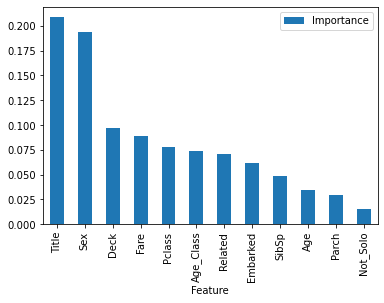

In [48]:
importances.plot.bar()

### Confusion Matrix, Precision, Recall, and F1 Score

Precision: 79.34%
Recall: 70.76%
F1 Score:  74.81%


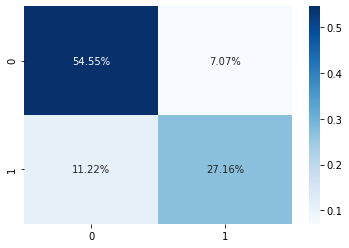

In [53]:
pred = cross_val_predict(clf, X_tr, y_tr, cv=3)
cf_matrix = confusion_matrix(y_tr, pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
print(f"Precision: {precision_score(y_tr, pred) :.2%}")
print(f"Recall: {recall_score(y_tr, pred) :.2%}")
print(f"F1 Score: {f1_score(y_tr, pred) : .2%}")
fig 

### ROC AUC Curve

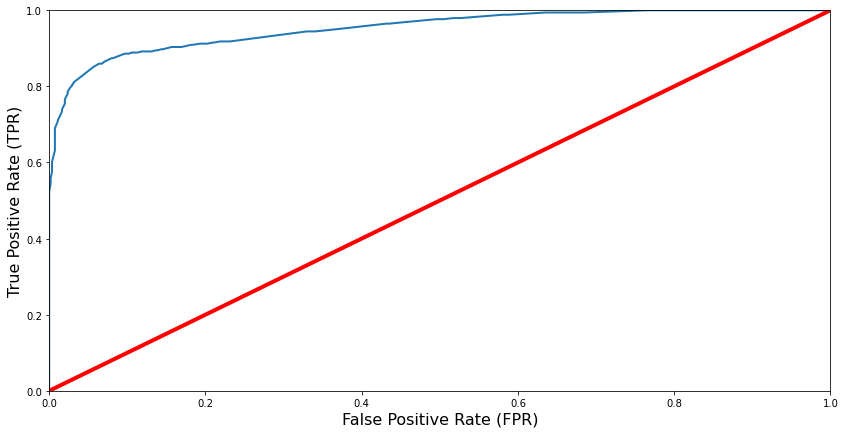

<Figure size 432x288 with 0 Axes>

In [57]:
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_tr, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()
plt.savefig('roc_auc_curve.png')

### ROC AUC Score

In [66]:
r_a_score = roc_auc_score(y_tr, y_scores)
print("ROC AUC Score:", r_a_score)

ROC-AUC-Score: 0.9301334696790549
